In [11]:
import numpy as np
import pandas as pd
import matplotlib
import re

In [12]:
data = np.genfromtxt('./historical-hourly-weather-data/temperature.csv', delimiter=',', names=True)
data = pd.read_csv('./historical-hourly-weather-data/temperature.csv')

In [13]:
data[['datetime', 'Toronto']].to_csv('./toronto-temperature2012-2017.csv')

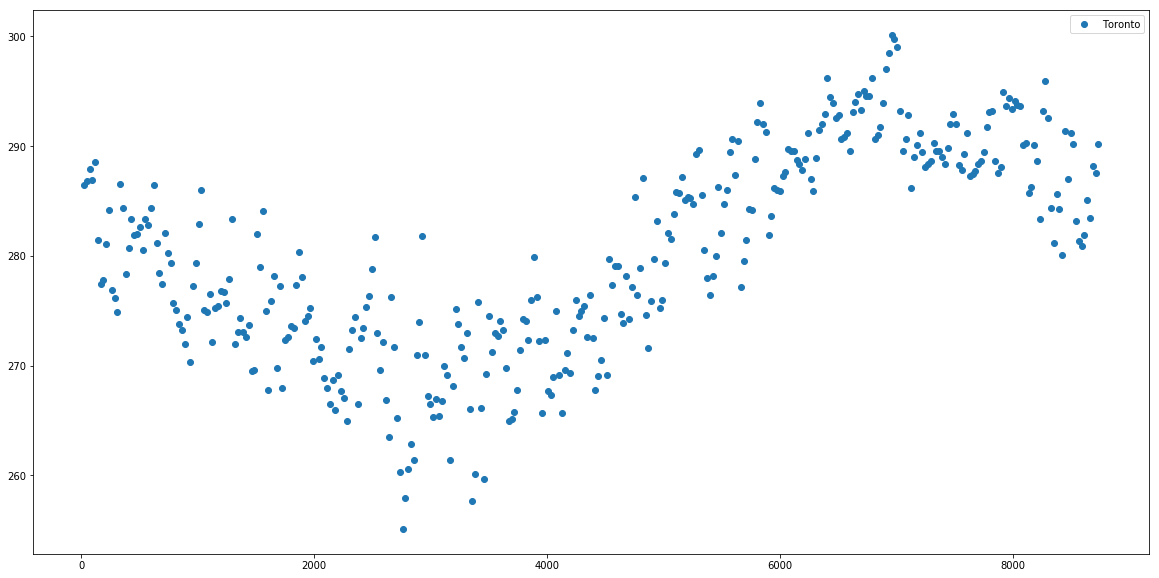

In [14]:
data[['datetime', 'Toronto']][0:24*365:24].plot(style=['o','rx'], figsize=(20, 10))

In [15]:
def get_data(file):
    data = []
    with open(file) as f:
        lines = f.readlines()[2:]
        for line in lines:
            tokens = line.split(',')
            tokens = [tokens[0], tokens[29]]
            tokens = re.findall(r"[\w']+", tokens[0])[:-2] + tokens[1:]
            if tokens[-1] != '':
                data.append(tokens)
    print(data)
    return data

data = get_data('./historical-hourly-weather-data/temperature.csv')

[['2012', '10', '01', '13', '285.83'], ['2012', '10', '01', '14', '285.834649953'], ['2012', '10', '01', '15', '285.847789539'], ['2012', '10', '01', '16', '285.860929124'], ['2012', '10', '01', '17', '285.874068709'], ['2012', '10', '01', '18', '285.887208294'], ['2012', '10', '01', '19', '285.90034788'], ['2012', '10', '01', '20', '285.913487465'], ['2012', '10', '01', '21', '285.92662705'], ['2012', '10', '01', '22', '285.939766635'], ['2012', '10', '01', '23', '285.952906221'], ['2012', '10', '02', '00', '285.966045806'], ['2012', '10', '02', '01', '285.979185391'], ['2012', '10', '02', '02', '285.992324977'], ['2012', '10', '02', '03', '286.005464562'], ['2012', '10', '02', '04', '286.018604147'], ['2012', '10', '02', '05', '286.031743732'], ['2012', '10', '02', '06', '286.044883318'], ['2012', '10', '02', '07', '286.058022903'], ['2012', '10', '02', '08', '286.071162488'], ['2012', '10', '02', '09', '286.084302074'], ['2012', '10', '02', '10', '286.097441659'], ['2012', '10', '02

In [16]:
def normalize_x(line):
    line[0] = float(line[0]) / 5000
    line[1] = (float(line[1]) - 1) / 12
    line[2] = (float(line[2]) - 1) / 31
    line[3] = float(line[3]) / 24
    return line

def normalize_y(temp):
    temp = float(temp) / 350
    return temp

def normalize_data(data):
    new_data = []
    for line in data:
        x = line[:-1]
        y = line[-1]
        new_data.append(normalize_x(x) + [normalize_y(y)])
    return new_data

new_data = normalize_data(data)

In [17]:
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
X = np.array([line[:-1] for line in new_data])
Y = np.array([line[-1] for line in new_data])

In [19]:
model = baseline_model()

model.fit(X, Y, epochs=5, batch_size=100)

model.save('model.h5')

Epoch 1/5
45250/45250 [==============================] - 36s 804us/step - loss: 0.0514
Epoch 2/5
45250/45250 [==============================] - 32s 707us/step - loss: 9.1903e-04
Epoch 3/5
45250/45250 [==============================] - 32s 706us/step - loss: 3.1962e-04
Epoch 4/5
45250/45250 [==============================] - 31s 678us/step - loss: 2.9153e-04
Epoch 5/5
45250/45250 [==============================] - 31s 680us/step - loss: 2.9337e-04


In [20]:
print(model.evaluate(X, Y))

45250/45250 [==============================] - 12s 275us/step
0.00028726912144756776


In [21]:
data_x = X[-1].reshape((4, 1))
print(data_x.shape)
model.predict(data_x.reshape((1, 4)))[0] * 350

(4, 1)


array([273.09137], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt

plt.plot((model.predict(X) * 350)[:720*24:24])
plt.ylabel('temperature')
plt.show()

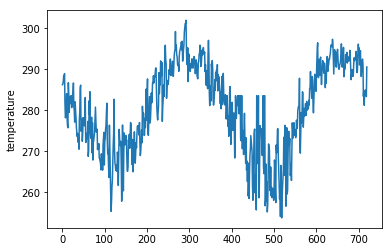

In [47]:
import matplotlib.pyplot as plt
import matplotlib

plt.plot((Y * 350)[:720*24:24])
plt.ylabel('temperature')
plt.show()

In [70]:
data_x = []
data_orig = []
for day in range(1, 32):
    for hour in range(0, 24):
        data_orig.append("%4d-%02d-%02d %02d:00:00" % (2017, 12, day, hour))
        data_x.append(normalize_x([str(2017),  str(12), str(day), str(hour)]))
days = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
for month in range(1, 13):
    for day in range(1, days[month] + 1):
        for hour in range(0, 24):
            data_orig.append("%4d-%02d-%02d %02d:00:00" % (2018, month, day, hour))
            data_x.append(normalize_x([str(2018),  str(month), str(day), str(hour)]))
data_x
data_x = np.array(data_x)
data_y = model.predict(data_x) * 350
n = len(data_y)

In [72]:
new_csv = np.append(np.array(data_orig).reshape(n, 1), data_y, axis=1)

In [153]:
import pandas as pd
df=pd.read_csv('./montreal-temperature2012-2017.csv', sep=',',header=1)
arr = df.values[:,1:]

In [154]:
arr

array([['2012-10-01 13:00:00', 285.83],
       ['2012-10-01 14:00:00', 285.834649953],
       ['2012-10-01 15:00:00', 285.847789539],
       ...,
       ['2017-11-29 22:00:00', 273.48],
       ['2017-11-29 23:00:00', 272.48],
       ['2017-11-30 00:00:00', 271.8]], dtype=object)

In [155]:
arr.shape

(45252, 2)

In [156]:
new_csv.shape

(9504, 2)

In [159]:
sol = np.append(arr, new_csv, axis = 0)

In [160]:
sol

array([['2012-10-01 13:00:00', 285.83],
       ['2012-10-01 14:00:00', 285.834649953],
       ['2012-10-01 15:00:00', 285.847789539],
       ...,
       ['2018-12-31 21:00:00', '273.2975'],
       ['2018-12-31 22:00:00', '274.6913'],
       ['2018-12-31 23:00:00', '276.08514']], dtype=object)

In [161]:
sol.shape

(54756, 2)

In [163]:
import pandas as pd 
df = pd.DataFrame(sol)
df.to_csv("montreal-2012-2018.csv")

In [180]:
df[1]

0           285.83
1          285.835
2          285.848
3          285.861
4          285.874
5          285.887
6            285.9
7          285.913
8          285.927
9           285.94
10         285.953
11         285.966
12         285.979
13         285.992
14         286.005
15         286.019
16         286.032
17         286.045
18         286.058
19         286.071
20         286.084
21         286.097
22         286.111
23         286.124
24         286.137
25          286.15
26          287.55
27          288.14
28          288.69
29          288.94
           ...    
54726    272.08966
54727     272.4518
54728      272.814
54729    273.17612
54730     273.8056
54731     275.1994
54732     273.3237
54733     272.7455
54734     272.1673
54735     271.5891
54736     271.0109
54737     270.4327
54738    269.85452
54739     269.2775
54740     269.3255
54741    269.47427
54742    269.62305
54743    269.83093
54744    270.12524
54745    270.41953
54746     270.7138
54747     27